<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: 
# AMI3, AmiAnalyze

<span style="color:red"> **Instruments Affected**</span>: NIRISS 

### Table of Contents
Follow this general outline. Additional sections may be added and others can be excluded, as needed. Sections in with a (\*) symbol are required.

<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Set up Temporary Directory](#tempdir)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Perform Tests and Visualization](#testing) 
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This notebook runs the `AmiAnalyze` step of the `calwebb_ami3` stage of the pipeline. The results are compared against results from the stand-alone `implaneia` code to verify that the algorithm is implemented correctly.

For more information on the `calwebb_ami3` pipeline stage visit the links below. 

> Stage description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_ami3.html
>
> Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/ami

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

`AmiAnalyze` is based on the `implaneia` algorithm:
> https://github.com/anand0xff/ImPlaneIA/tree/delivery


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

Calibrator: reference star to measure PSF to calibrate out instrumental contributions to the interferometric observables 

PSF: point spread function

Target: source of interest for science program 

[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

This notebooks assesses consistency between the output of ImPlaneIA and the AMI3 step of the pipeline, which is based on ImPlaneIA. The notebook checks the following parameters for consistency between ImPlaneIA and AMI3:
- Peak of PSF in analytical model
- Maximum and minimum pixel values in residual (data - model) image
- Kurtosis of residuals
- Closure amplitudes 
- Closure phases 
- Fringe amplitudes 
- Fringe phases
- Pistons
- Solutions


The notebook also produces the following plots for inspection, from both the pipeline and ImPlaneIA:
- Analytical model image
- Residual image
- Pixel values of residuals
- Closure amplitude index vs closure amplitude
- Closure phase index vs closure phases
- Fringe amplitude index vs closure amplitude
- Fringe phase index vs fringe phases
- Aperture index vs pistons
- Solutions index vs solutions
- Scatter plots between values derived from pipeline vs ImPlaneIA for following parameters:
    - closure amplitudes
    - closure phases
    - fringe amplitudes
    - fringe phases
    - piston
    - solutions

[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

We simulated point source data with ImPlaneIA. The name of the simulated image is `all_effects_data.fits`. This data is rotated by 2 degrees, has simulated pistons and is offset from the pixel center. ImPlaneIA was used to analyze the data. 

The following files store the results from analyzing all_effects_data.fits with ImPlaneIA:

| Filename        | Description|
|:----------------|:-----------|
|modelsolution_00.fits | Analytical model created by ImPlaneIA |
|residual_00.fits      | data - model |
|CAs_00.txt            | 35 closure amplitudes|
|CPs_00.txt            | 35 closure phases |
|amplitudes_00.txt     | 21 fringe amplitudes |
|phases_00.txt         | 35 fringe phases |
|fringepistons_00.txt  | 7 pistons (optical path delays between mask holes) |
|solutions_00.txt      | 44 fringe coefficients of terms in the analytical model |

We then simulated binary point source data with Mirage and replaced the data part of the file with data simulated with ImPlaneIA. For comparing ImPlaneIA with pipeline we need to run both ImPlaneIA and the pipeline on the same data. We cannot run delivered version (May 2020) of ImPlaneIA on Mirage data because of recent changes to CDELT1 and CDELT2 pipeline header keywords that are required by ImPlaneIA. We are therefore using data simulated by ImPlaneIA for the comparison. 

We will use `jw01093001001_01101_00005_nis_cal.fits` only to get headers required by the pipeline to process the data. The SCI extension for this file will come from the file `all_effects_data.fits` that was simulated with ImPlaneIA.  The configuration file that will be used for the AmiAnalyze stage of the pipeline is `ami_analyze.cfg`.

[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory

[Top of Page](#title_ID)

In [1]:
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    odir = data_dir.name
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpq6rmysnb


In [2]:
# Choose CRDS cache location
use_local_crds_cache = False
crds_cache_tempdir = False
crds_cache_notebook_dir = True
crds_cache_home = False
crds_cache_custom_dir = False
crds_cache_dir_name = ""

if use_local_crds_cache:
    if crds_cache_tempdir:
        os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_notebook_dir:
        try:
            os.environ['CRDS_PATH'] = os.path.join(orig_dir, "crds")
        except Exception as e:
            os.environ['CRDS_PATH'] = os.path.join(os.getcwd(), "crds")
    elif crds_cache_home:
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif crds_cache_custom_dir:
        os.environ['CRDS_PATH'] = crds_cache_dir_name

<a id="imports"></a>
# Imports
List the package imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* numpy for working with arrays
* IPython.display for printing markdown output
* scipy.stats to calculate kurtosis of distribution of pixel values in image
* jwst.datamodels for building model for JWST Pipeline
* jwst.pipeline.collect_pipeline_cfgs for gathering configuration files
* jwst.ami to call the AMI Analyze step
* from ci_watson.artifactory_helpers import get_bigdata for reading data from Artifactory
* matplotlib.pyplot.plt to generate plots


[Top of Page](#title_ID)

In [3]:
from astropy.io import fits
import numpy as np
from IPython.display import Markdown
from scipy.stats import kurtosis 

from jwst.pipeline.collect_pipeline_cfgs import collect_pipeline_cfgs
from jwst.ami import AmiAnalyzeStep 
import jwst.datamodels as datamodels

from ci_watson.artifactory_helpers import get_bigdata

import matplotlib.pyplot as plt

<a id="data_load"></a>
# Loading the Data

[Top of Page](#title_ID)

In [4]:
# Load simulation files:
# Load data simulated with Mirage
imold_f = get_bigdata('jwst_validation_notebooks',
                      'validation_data',
                      'ami_analyze',
                      'jw01093001001_01101_00005_nis_cal.fits')
# Load data simulated with ImPlaneIA
newdata_f = get_bigdata('jwst_validation_notebooks',
                        'validation_data',
                        'ami_analyze',
                        'all_effects_data.fits')

# Load configuration file
cfg_file = get_bigdata('jwst_validation_notebooks',
                       'validation_data',
                       'ami_analyze',
                       'ami_analyze.cfg')

# Load results files from ImPlaneIA that we'll use to verify results
im_model_f = get_bigdata('jwst_validation_notebooks',
                         'validation_data',
                         'ami_analyze',
                         'modelsolution_00.fits')
im_residual_f = get_bigdata('jwst_validation_notebooks',
                            'validation_data',
                            'ami_analyze',
                            'residual_00.fits')
# closure amplitudes:
ca_impl_f = get_bigdata('jwst_validation_notebooks',
                        'validation_data',
                        'ami_analyze',
                        'CAs_00.txt')
# closure phases:
cp_impl_f = get_bigdata('jwst_validation_notebooks',
                        'validation_data',
                        'ami_analyze',
                        'CPs_00.txt')
# fringe amplitudes
fringeampl_impl_f = get_bigdata('jwst_validation_notebooks',
                                'validation_data',
                                'ami_analyze',
                                'amplitudes_00.txt')
# fringe phases
fringephase_impl_f = get_bigdata('jwst_validation_notebooks',
                                 'validation_data',
                                 'ami_analyze',
                                 'phases_00.txt')
# pistons
pistons_impl_f = get_bigdata('jwst_validation_notebooks',
                             'validation_data',
                             'ami_analyze',
                             'fringepistons_00.txt')
# solutions (fringe coefficients of the 44 terms in the analytical model)
solutions_impl_f = get_bigdata('jwst_validation_notebooks',
                               'validation_data',
                               'ami_analyze',
                               'solutions_00.txt')

## Create dataset to run through AmiAnalyzeStep
Open up the Mirage simulation which has the header info we want:

In [5]:
imold = fits.open(imold_f)
# show what's in the file:
imold.info()

Filename: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpq6rmysnb/jw01093001001_01101_00005_nis_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     250   ()      
  1  SCI           1 ImageHDU        46   (80, 80)   float32   
  2  ERR           1 ImageHDU        10   (80, 80)   float32   
  3  DQ            1 ImageHDU        11   (80, 80)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (80, 80)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (80, 80)   float32   
  6  VAR_FLAT      1 ImageHDU         9   (80, 80)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [16407B]   


Fetch data simulated with ImPlaneIA and combine with header from file above:

In [6]:
newdata = fits.getdata(newdata_f)
imold[1].data = newdata
imold.writeto("dataset_for_amianalyze.fits", overwrite=True)

# Modify a keyword in each data file: only necessary for now
# Next three lines are temporary to accommodate recent changes to Mirage and pipeline
# and for Mirage to work with the pipeline.
df = "dataset_for_amianalyze.fits"
with datamodels.open(df) as model:
        model.meta.dither.dither_points = int(model.meta.dither.dither_points)
        model.save(df)

<a id="pipeline"></a>
# Run the AMI Analyze step of the pipeline

[Top of Page](#title_ID)

In [7]:
result = AmiAnalyzeStep.call("dataset_for_amianalyze.fits", 
                             config_file=cfg_file,
                             output_dir=odir, save_results=True)

2021-08-20 14:07:17,043 - stpipe.ami_analyze - INFO - AmiAnalyzeStep instance created.


2021-08-20 14:07:17,186 - stpipe.ami_analyze - INFO - Step ami_analyze running with args ('dataset_for_amianalyze.fits',).


2021-08-20 14:07:17,188 - stpipe.ami_analyze - INFO - Step ami_analyze parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpq6rmysnb', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'oversample': 3, 'rotation': 0.0, 'psf_offset': '0.0 0.0', 'rotation_search': '-3 3.1 1.'}


2021-08-20 14:07:17,189 - stpipe.ami_analyze - INFO - Oversampling factor =  3


2021-08-20 14:07:17,189 - stpipe.ami_analyze - INFO - Initial rotation guess = 0.0 deg


2021-08-20 14:07:17,190 - stpipe.ami_analyze - INFO - Initial values to use for psf offset = [0.0, 0.0]


2021-08-20 14:07:17,284 - stpipe.ami_analyze - INFO - Using filter throughput reference file /grp/crds/cache/references/jwst/jwst_niriss_throughput_0008.fits


2021-08-20 14:07:17,359 - stpipe.ami_analyze - INFO - Initial values to use for rotation search [-3. -2. -1.  0.  1.  2.  3.]


2021-08-20 14:07:33,936 - stpipe.ami_analyze - INFO - Saved model in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpq6rmysnb/dataset_for_amianalyze_ami_analyze.fits


2021-08-20 14:07:33,940 - stpipe.ami_analyze - INFO - Step ami_analyze done


## Parse output of pipeline processing

Inspect extensions of processed file

In [8]:
output_filename = result.meta.filename
im_sim = fits.open(os.path.join(odir,output_filename))
im_sim.info()

Filename: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpq6rmysnb/dataset_for_amianalyze_ami_analyze.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     258   ()      
  1  FIT           1 ImageHDU         9   (79, 79)   float32   
  2  RESID         1 ImageHDU         9   (79, 79)   float32   
  3  CLOSURE_AMP    1 BinTableHDU     12   35R x 1C   [D]   
  4  CLOSURE_PHA    1 BinTableHDU     12   35R x 1C   [D]   
  5  FRINGE_AMP    1 BinTableHDU     12   21R x 1C   [D]   
  6  FRINGE_PHA    1 BinTableHDU     12   21R x 1C   [D]   
  7  PUPIL_PHA     1 BinTableHDU     12   7R x 1C   [D]   
  8  SOLNS         1 BinTableHDU     12   44R x 1C   [D]   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [5949B]   


### Parse output from pipeline processed file:

In [9]:
# closure amplitudes
ca_pipe = im_sim['CLOSURE_AMP'].data

# closure phases
cp_pipe = im_sim['CLOSURE_PHA'].data

# fringe amplitudes
fringeamp_pipe = im_sim['FRINGE_AMP'].data

# fringe phases
fringephase_pipe = im_sim['FRINGE_PHA'].data

# pistons
pistons_pipe = im_sim['PUPIL_PHA'].data

# solutions (fringe coefficients of the 44 terms in the analytical model)
solns_pipe = im_sim['SOLNS'].data

# analytical model created by the pipeline
fit = im_sim['FIT'].data

# residual: data - model
resid = im_sim['RESID'].data

### Parse ImPlaneIA results: model and residual

In [10]:
im_model = fits.getdata(im_model_f)
im_residual = fits.getdata(im_residual_f)

<a id="testing"></a>
# Perform Tests and Visualization
## Do fit parameters derived from the pipeline match those calculated from ImPlaneIA?

[Top of Page](#title_ID)

### Set tolerances here 
If differences bewtween pipeline and ImPlaneIA values are below these thresholds, the test passes

In [11]:
# tolerance on relative error between ImPlaneIA and pipeline values
tol = 1e-4

# Tolerances for using numpy.isclose routine, to define the relative and absolute tolerances (rtol, atol)
rtol = 0.0
atol = 9e-2

## Define routines to use for testing

Routine to calculate relative error between values from ImPlaneIA and pipeline

In [12]:
def calc_rel_error(implaneia_value, pipe_value):
    
    rel_err = np.abs(implaneia_value - pipe_value)/implaneia_value
    
    return(rel_err)

Define assertion test to check whether relative error between parameters is within acceptable tolerance

In [13]:
def test_assertion(implaneia_value, pipe_value, parameter_test, tol=tol):
    
    rel_err = calc_rel_error(implaneia_value, pipe_value)
    
    test_condition = rel_err < tol
    
    try:
        assert(test_condition)
        print("Relative error in {} agrees within tolerance of {} (test passed)".format(parameter_test, tol))
    except AssertionError as e:
        print("\nTEST FAILED!!")
        print("Relative error in {} did NOT within tolerance of {}".format(parameter_test, tol))

    # Print out values for reference:
    print("ImPlaneIA value = {}".format(implaneia_value))
    print("Pipeline value = {}\n".format(pipe_value))

Routine to calculate the mean and standard deviation in the difference between the ImPlaneIA and pipeline values and test whether they're within the pre-defined tolerance

In [14]:
def run_stats_assert(lg, pipe, parameter_test, tol=tol):
    
    mean_diff = np.mean(abs(lg - pipe))
    stdev_diff = np.std(abs(lg - pipe))
    
    test_condition = (mean_diff < tol) & (stdev_diff < tol)
    
    try:
        assert(test_condition)
        print("Mean and standard deviation in difference of {} agrees within tolerance of {} (test passed)".\
              format(parameter_test, tol))
    except AssertionError as e:
        print("\nTEST FAILED!!")
        print("Mean and standard deviation in difference of {} did NOT within tolerance of {}".\
              format(parameter_test, tol))

    # Print out values for reference:
    print("Mean difference value = {}".format(mean_diff))
    print("Standard deviation difference value = {}\n".format(stdev_diff))

Routine to check whether values from ImPlaneIA processing and pipeline processing agree within specified tolerance

In [15]:
def isclose_assert(implaneia_array, pipe_array, parameter_test, rtol=rtol, atol=atol):

    test_condition = np.isclose(implaneia_array, pipe_array, rtol, atol, equal_nan = False).all()
    
    try:
        assert(test_condition)
        print("Pipeline value are within {:0.2e} of ImPlaneIA values for {} (test passed)\n".\
              format(atol, parameter_test))
    except AssertionError as e:
        print("\nTEST FAILED!!")
        print("Pipeline value are NOT within {:0.2e} of ImPlaneIA values for {}\n".\
             format(atol, parameter_test))

Routine for making comparison plots of index versus parameter value: 

In [16]:
def plot_index_v_par(impl, pipe, parameter, ylim=None):
    
    plt.figure(figsize = (12, 6))
    
    # ImPlaneIA value:
    plt.plot(impl, color = 'green', linestyle = 'dashed', marker = 'o', 
         markerfacecolor = 'blue', markersize = 6, label = parameter + " ImPlaneIA")
    
    # Pipeline value
    plt.plot(pipe, color = 'purple', linestyle = 'dashed', marker = '*', 
         markerfacecolor = 'red', markersize = 8, label = parameter + " pipeline")
    
    plt.legend(loc = "upper right")
    
    # Label axes and title
    plt.xlabel(parameter + " index", fontsize = 14)
    plt.ylabel(parameter , fontsize = 14)
    plt.title("Comparison of " + parameter, fontsize = 16)
    
    # Limit y-axis of tuple of limits provided
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.show()

Routine for making scatter plots to compare pipeline observables with those from ImPlaneIA

In [17]:
def scatt_plot(impl, pipe, param):
    
    plt.plot(impl, pipe, '.')
    
    # plot line where quantities are equal
    xlims = plt.xlim()
    ylims = plt.ylim()
    plt.plot(xlims,ylims, color='grey')
    plt.xlim(xlims)
    plt.ylim(ylims)
    
    # overplot data points
    plt.scatter(impl, pipe,color='blue')
    
    # Label plot
    plt.title(param)
    plt.ylabel(param + " from AMI level3 pipeline")
    plt.xlabel(param + " from ImPlaneIA")
    
    plt.tight_layout()

## Testing cells begin here

### Compare peak of PSF and maximum and minimum values in residual image

Relative error in PSF peak agrees within tolerance of 0.0001 (test passed)
ImPlaneIA value = 3607.175573418164
Pipeline value = 3607.175537109375

**Data peak** (input data): 3607.0632302190543


Relative error in Maximum pixel of residual image agrees within tolerance of 0.0001 (test passed)
ImPlaneIA value = 13.132900657889877
Pipeline value = 13.133195877075195

Relative error in Minimum pixel of residual image agrees within tolerance of 0.0001 (test passed)
ImPlaneIA value = -14.62593854551534
Pipeline value = -14.625658988952637



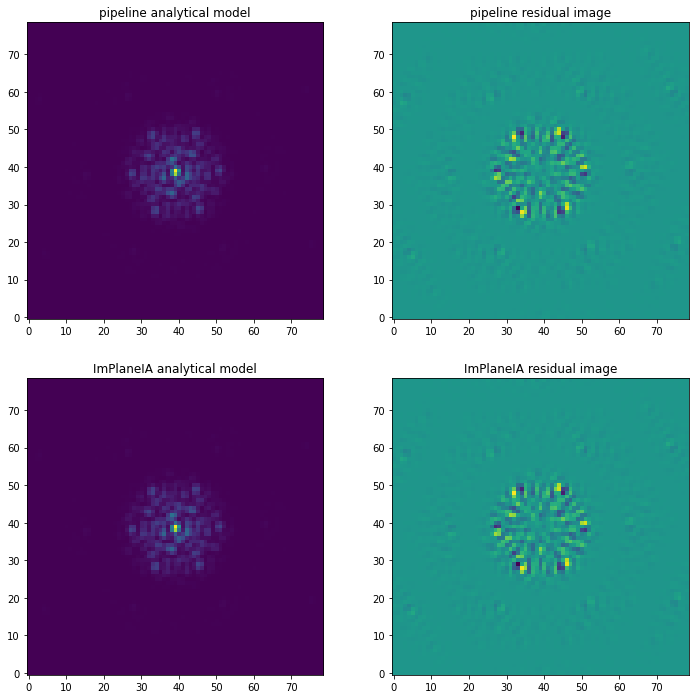

In [18]:
# Compare peak of PSF
test_assertion(im_model.max(), fit.max(), 'PSF peak')
# Print the PSF data peak is in input data for reference
print("**Data peak** (input data): {}\n\n".format(newdata.max()))

# Compare maximum pixel value
test_assertion(im_residual.max(), resid.max(), 'Maximum pixel of residual image')

# Compare minimum pixel value
test_assertion(im_residual.min(), resid.min(), 'Minimum pixel of residual image')

# Plot the analytical model and residual images for reference
f = plt.figure(figsize = (12, 12))
plt.subplot(2, 2, 1)
plt.title("pipeline analytical model")
plt.imshow(fit, origin='lower')
plt.subplot(2, 2, 2)
plt.title("pipeline residual image")
plt.imshow(resid, origin='lower')
plt.subplot(2, 2, 3)
plt.imshow(im_model, origin='lower')
plt.title("ImPlaneIA analytical model")
plt.subplot(2, 2, 4)
plt.imshow(im_residual, origin='lower')
plt.clim(im_residual.min(), im_residual.max())
plt.title("ImPlaneIA residual image")
plt.show(block = True)

### Compare residual images

Relative error in Kurtosis of residual image agrees within tolerance of 0.0001 (test passed)
ImPlaneIA value = 43.272199426302315
Pipeline value = 43.271835242577744



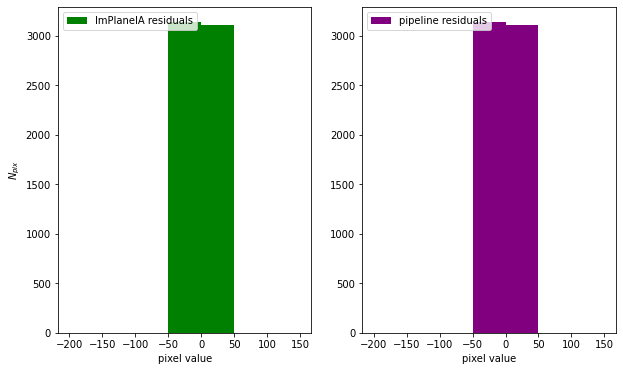

In [19]:
# Compare kurtosis of pixel values in residual images
test_assertion(kurtosis(np.ravel(im_residual)), kurtosis(np.ravel(resid)), 
               'Kurtosis of residual image')

# Plot histogram of residual images
plt.figure(figsize = (10, 6))
plt.subplot(1, 2, 1)
plt.hist(np.ravel(im_residual), bins = np.arange(-200, 200, 50), color = 'green', label = 'ImPlaneIA residuals')
plt.legend(fontsize = 10)
plt.xlabel('pixel value', fontsize = 10)
plt.ylabel('$N_{pix}$', fontsize = 10)
plt.subplot(1, 2, 2)
plt.hist(np.ravel(resid),bins = np.arange(-200, 200, 50), color = 'purple', label = 'pipeline residuals')
plt.xlabel('pixel value', fontsize = 10)
plt.legend(fontsize = 10)
plt.show()

### Compare closure amplitudes

Mean and standard deviation in difference of closure amplitude agrees within tolerance of 0.0001 (test passed)
Mean difference value = 1.590345879114758e-08
Standard deviation difference value = 1.0145959411163996e-08

Pipeline value are within 9.00e-02 of ImPlaneIA values for closure amplitude (test passed)



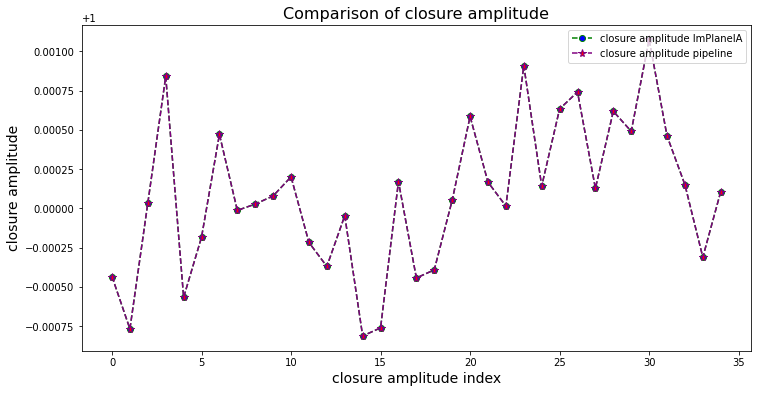

In [20]:
param = 'closure amplitude'

ca_pipeline = [x[0] for x in ca_pipe]
ca_impl = np.loadtxt(ca_impl_f)

# Calculate mean and std of differences in closure phases
run_stats_assert(ca_impl, ca_pipeline, param)

# Check tolerance:
isclose_assert(ca_impl, ca_pipeline, param)

# Plot closure amplitudes
plot_index_v_par(ca_impl, ca_pipeline, param)

### Compare closure phases

Mean and standard deviation in difference of closure phases agrees within tolerance of 0.0001 (test passed)
Mean difference value = 1.5709630898522572e-08
Standard deviation difference value = 1.3058138481027137e-08

Pipeline value are within 9.00e-02 of ImPlaneIA values for closure phases (test passed)



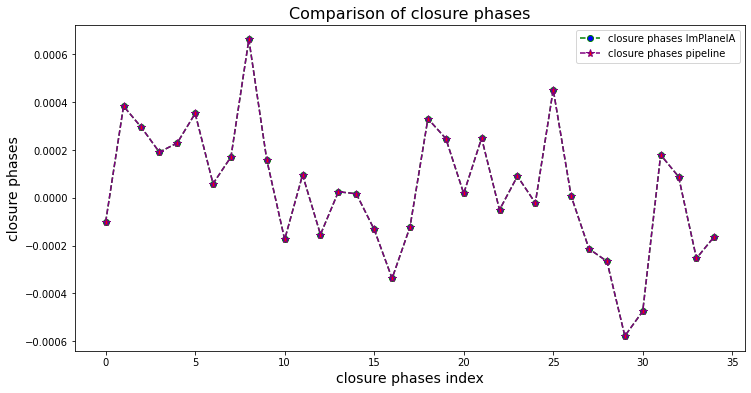

In [21]:
param = 'closure phases'

cp_pipeline = [x[0] for x in cp_pipe]
cp_impl = np.loadtxt(cp_impl_f)

# Calculate mean and std of differences in closure phases
run_stats_assert(cp_impl, cp_pipeline, param)

# Check tolerance:
isclose_assert(cp_impl, cp_pipeline, param)

# Plot closure phases
plot_index_v_par(cp_impl, cp_pipeline, param)

### Compare fringe amplitudes

Mean and standard deviation in difference of fringe amplitudes agrees within tolerance of 0.0001 (test passed)
Mean difference value = 1.047138746612135e-08
Standard deviation difference value = 8.506604880702767e-09

Pipeline value are within 9.00e-02 of ImPlaneIA values for fringe amplitudes (test passed)



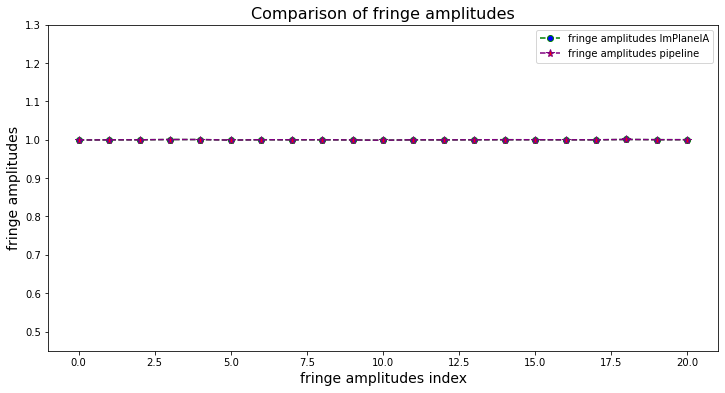

In [22]:
param = 'fringe amplitudes'

fringeamp_pipeline = [x[0] for x in fringeamp_pipe]
fringeamp_impl = np.loadtxt(fringeampl_impl_f)

# Calculate mean and std of differences in fringe amplitudes
run_stats_assert(fringeamp_impl, fringeamp_pipeline, param)

# Check tolerance:
isclose_assert(fringeamp_impl, fringeamp_pipeline, param)

# Plot fringe amplitudes
plot_index_v_par(fringeamp_impl, fringeamp_pipeline, param, ylim=(0.45,1.3))

### Compare fringe phases

Mean and standard deviation in difference of fringe phases agrees within tolerance of 0.0001 (test passed)
Mean difference value = 4.122853947571968e-06
Standard deviation difference value = 2.46086887268052e-06

Pipeline value are within 9.00e-02 of ImPlaneIA values for fringe phases (test passed)



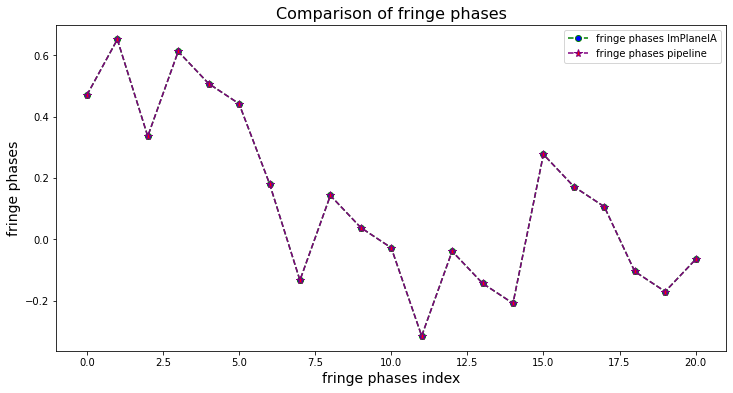

In [23]:
param = 'fringe phases'
fringephase_pipeline = [x[0] for x in fringephase_pipe]
fringephase_impl = np.loadtxt(fringephase_impl_f)

# Calculate mean and std of differences in fringe phases
run_stats_assert(fringephase_impl, fringephase_pipeline, param)

# Check tolerance:
isclose_assert(fringephase_impl, fringephase_pipeline, param)

# Plot fringe phases
plot_index_v_par(fringephase_impl, fringephase_pipeline, param)

### Compare pistons

[-0.43122597298805393, 0.03847247514634235, 0.21993847941860512, -0.09541017062941534, 0.1811588353038523, 0.0763144116140602, 0.010751942134609269] pistons pipeline
[-0.43122622  0.03847633  0.21993445 -0.09540619  0.18116091  0.07631059
  0.01075013] pistons ImPlaneIA
Mean and standard deviation in difference of pistons agrees within tolerance of 0.0001 (test passed)
Mean difference value = 2.8304161051942445e-06
Standard deviation difference value = 1.3670779823256655e-06

Pipeline value are within 9.00e-02 of ImPlaneIA values for pistons (test passed)



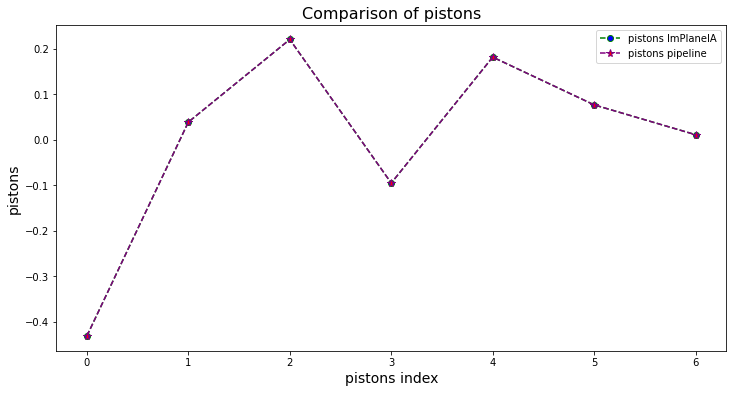

In [24]:
param = 'pistons'
pistons_pipeline = [x[0] for x in pistons_pipe]
pistons_impl = np.loadtxt(pistons_impl_f)

# Print piston values for reference
print(pistons_pipeline, "pistons pipeline")
print(pistons_impl, "pistons ImPlaneIA")

# Calculate mean and std of differences in pistons
run_stats_assert(pistons_impl, pistons_pipeline, param)

# Check tolerance:
isclose_assert(pistons_impl, pistons_pipeline, param)

# Plot pistons
plot_index_v_par(pistons_impl, pistons_pipeline, param)

### Compare solutions

Mean and standard deviation in difference of solutions agrees within tolerance of 0.0001 (test passed)
Mean difference value = 2.3086670019295217e-06
Standard deviation difference value = 2.3810726510631115e-06

Pipeline value are within 9.00e-02 of ImPlaneIA values for solutions (test passed)



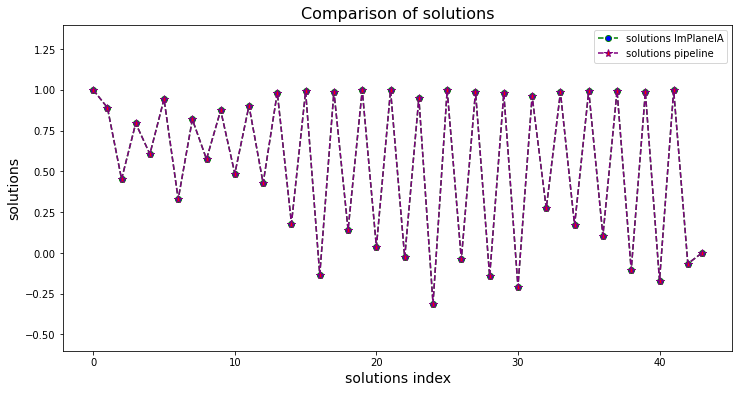

In [25]:
param = 'solutions'
solutions_pipeline = [x[0] for x in solns_pipe]
solutions_impl = np.loadtxt(solutions_impl_f)

# Calculate mean and std of differences in solutions
run_stats_assert(solutions_impl, solutions_pipeline, param)

# Check tolerance:
isclose_assert(solutions_impl, solutions_pipeline, param)

# Plot solutions
plot_index_v_par(solutions_impl, solutions_pipeline, param, ylim=(-0.6,1.4))

### Scatter plots of observables calculated from pipeline and ImPlaneIA

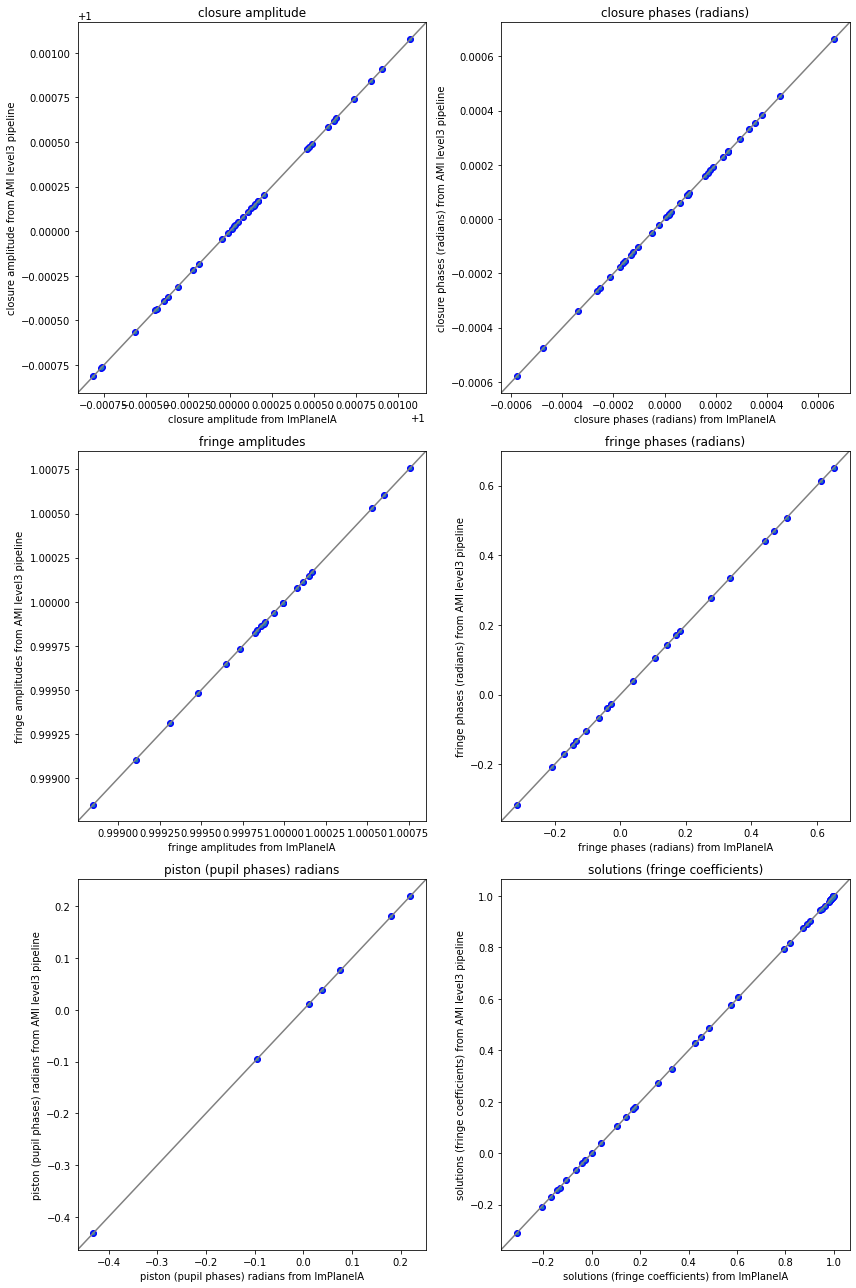

In [26]:
fig = plt.figure(figsize =(12, 18))
fig.subplots_adjust(wspace = .4,hspace = 0.3)

# Compare closure amplitudes
plt.subplot(3, 2, 1)
scatt_plot(ca_impl, ca_pipeline, 'closure amplitude')

# Compare closure phases
plt.subplot(3, 2, 2)
scatt_plot(cp_impl, cp_pipeline, 'closure phases (radians)')

# Compare fringe amplitudes
plt.subplot(3, 2, 3)
scatt_plot(fringeamp_impl, fringeamp_pipeline, 'fringe amplitudes')

# Compare fringe phases
plt.subplot(3, 2, 4)
scatt_plot(fringephase_impl, fringephase_pipeline, 'fringe phases (radians)')

# Compare pistons
plt.subplot(3, 2, 5)
scatt_plot(pistons_impl, pistons_pipeline, 'piston (pupil phases) radians')

# Compare solutions
plt.subplot(3, 2, 6)
scatt_plot(solutions_impl, solutions_pipeline, 'solutions (fringe coefficients)')

<a id="about_ID"></a>
## About this Notebook
**Authors:** Deepashri Thatte, Senior Staff Scientist, NIRISS
<br> Stepahanie LaMassa, Scientist, NIRISS
<br>**Updated On:** 08/12/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 